In [1]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti


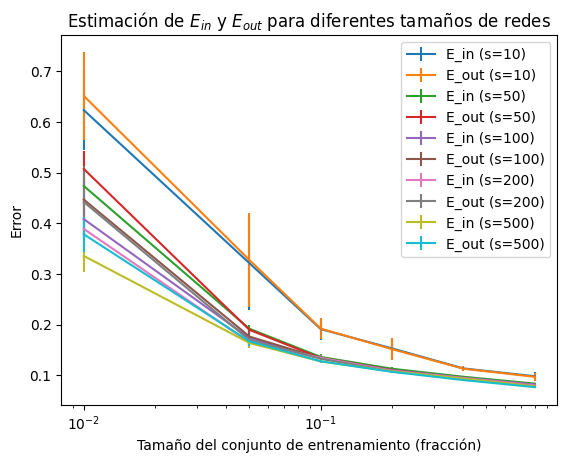

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Transformaciones de los datos
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Cargar el conjunto de datos MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Definir el modelo de una sola capa
class SingleLayerNN(nn.Module):
    def __init__(self, input_size, num_neurons):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(input_size, num_neurons)
        self.output = nn.Linear(num_neurons, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Aplanar las imágenes
        x = torch.relu(self.fc(x))
        x = self.output(x)
        return x

# Función para entrenar y probar el modelo
def train_and_evaluate(model, train_loader, test_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    # Entrenamiento
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Calcular el error en el conjunto de entrenamiento (E_in)
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    E_in = 1 - correct / total
    
    # Calcular el error en el conjunto de prueba (E_out)
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    E_out = 1 - correct / total

    return E_in, E_out

# Parámetros de los experimentos
s_values = [10, 50, 100, 200, 500]  # Tamaños de las redes
n_values = [0.01, 0.05, 0.1, 0.2, 0.4, 0.8]  # Fracciones del conjunto de entrenamiento
T = 10  # Número de repeticiones del experimento
epochs = 5  # Número de épocas de entrenamiento

# Inicializar listas para almacenar los resultados
results_in = {s: [] for s in s_values}
results_out = {s: [] for s in s_values}

# Realizar los experimentos
for s in s_values:
    for n in n_values:
        E_in_list, E_out_list = [], []
        for t in range(T):
            # Muestreo del conjunto de entrenamiento
            subset_size = int(len(train_dataset) * n)
            subset_indices = np.random.choice(len(train_dataset), subset_size, replace=False)
            subset_train = Subset(train_dataset, subset_indices)
            train_loader = DataLoader(subset_train, batch_size=64, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
            
            # Inicializar el modelo
            model = SingleLayerNN(28*28, s)
            
            # Entrenar y evaluar
            E_in, E_out = train_and_evaluate(model, train_loader, test_loader, epochs)
            E_in_list.append(E_in)
            E_out_list.append(E_out)

        # Calcular la media y desviación estándar de E_in y E_out
        mean_in, std_in = np.mean(E_in_list), np.std(E_in_list)
        mean_out, std_out = np.mean(E_out_list), np.std(E_out_list)
        
        results_in[s].append((n, mean_in, std_in))
        results_out[s].append((n, mean_out, std_out))

# Graficar los resultados
for s in s_values:
    n_values_plot = [r[0] for r in results_in[s]]
    mean_in_values = [r[1] for r in results_in[s]]
    std_in_values = [r[2] for r in results_in[s]]
    mean_out_values = [r[1] for r in results_out[s]]
    std_out_values = [r[2] for r in results_out[s]]
    
    plt.errorbar(n_values_plot, mean_in_values, yerr=std_in_values, label=f'E_in (s={s})')
    plt.errorbar(n_values_plot, mean_out_values, yerr=std_out_values, label=f'E_out (s={s})')

plt.xlabel('Tamaño del conjunto de entrenamiento (fracción)')
plt.ylabel('Error')
plt.legend()
plt.title('Estimación de $E_{in}$ y $E_{out}$ para diferentes tamaños de redes')
plt.xscale('log')
plt.show()
